### **Google Drive Mount**

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Import**

In [52]:
import random
import os
import multiprocessing
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import spatial

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

### **Versions**

- pandas - 1.5.3
- numpy - 1.23.5
- matplotlib - 3.7.1
- tqdm - 4.66.1
- sklearn - 1.2.2
- scipy - 1.10.1
- torch - 2.0.1+cu118 ver.

### **OS**
- Google Colab Pro+
- GPU - V100
- 고용량 RAM 사용

### **Hyperparameter Setting**

In [4]:
CFG = {
    'TRAIN_WINDOW_SIZE':60, # 60일치로 학습
    'PREDICT_SIZE':21, # 21일치 예측
    'EPOCHS':20,
    'LEARNING_RATE':0.000075,
    'BATCH_SIZE':1024,
    'SEED':777
}

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

### **데이터 불러오기**

In [6]:
# train.csv 파일 불러오기
train_df = pd.read_csv('/content/drive/MyDrive/train.csv')
brand_df = pd.read_csv('/content/drive/MyDrive/brand_keyword_cnt.csv')

### **데이터 전처리**

#### **interpolation**

In [7]:
for i in range(0, 15890):
  a, b = 414, 424 # 결측 구간 이전 10일 구간
  ee = 34 # 결측 일수

  z1 = train_df.iloc[i, -7:].sum() # 결측 구간 이후 7일동안의 값 더함
  z1 = round(z1 / 7) # 7일동안의 값 평균 계산

  for j in range(1, 35): # 결측 구간 보간 진행
    z = train_df.iloc[i, a:b].sum() # 결측 구간 이전 10일동안의 값 더함.
    z = round(z / 10) # 10일동안의 값 평균 계산
    sum = round(z - ((z - z1) / ee)) # 결측 이전 시점의 평균값과 결측 이후 시점의 평균값을 뺀 상태에서 남은 보간 일수만큼 나누어줌. 이후 결측 이전 시점의 평균값에 빼줌
    if sum <= 0: # 0일 경우 넘어감.
      continue
    else:
      train_df.iloc[i, b] += sum # 결측 구간에 계산된 값 삽입
    a += 1
    b += 1
    ee -= 1

train_df.tail(20)

,ID,제품,대분류,중분류,소분류,브랜드,2022-01-01,2022-01-02,2022-01-03,2022-01-04,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
15870,15870,B002-03798-00042,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-03798,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15871,15871,B002-03798-00043,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-03798,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15872,15872,B002-03798-00044,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-03798,0,0,0,0,...,6,4,1,1,0,0,3,0,3,0
15873,15873,B002-03798-00045,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-03798,0,0,0,0,...,1,1,0,0,0,0,0,0,1,0
15874,15874,B002-03798-00046,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-03798,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15875,15875,B002-03798-00047,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-03798,0,0,0,0,...,1,0,1,0,0,0,0,0,1,0
15876,15876,B002-03798-00048,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-03798,0,0,0,0,...,2,3,4,5,1,5,0,2,4,0
15877,15877,B002-03798-00049,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-03798,0,0,0,0,...,2,2,1,6,1,0,0,0,0,1
15878,15878,B002-03798-00050,B002-C001-0002,B002-C002-0009,B002-C003-0049,B002-03798,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15879,15879,B002-03798-00051,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-03798,0,0,0,0,...,0,0,0,0,0,0,0,5,4,22


<ipython-input-8-99bb19acb840>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_grouped = df0.groupby('대분류').sum().iloc[:, 5:].T


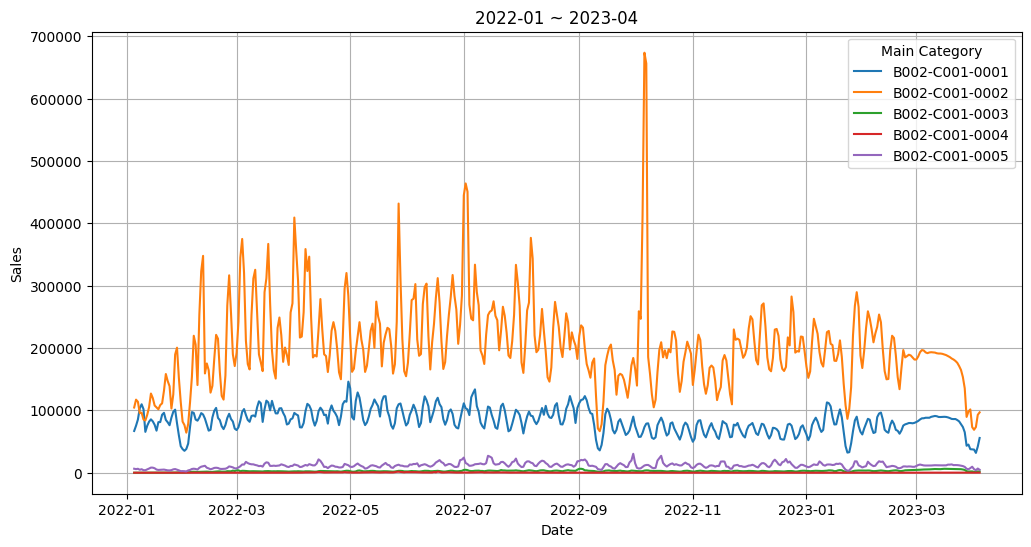

In [8]:
# 아래 코드는 보간이 잘 되었는지 시각화 하는 코드입니다.
df0 = train_df

# 대분류를 기준으로 2022-01-01부터 2023-04-04까지의 값을 더함
df_grouped = df0.groupby('대분류').sum().iloc[:, 5:].T

# 날짜를 Datetime 형식으로 변환
df_grouped.index = pd.to_datetime(df_grouped.index)

# 시각화
plt.figure(figsize=(12, 6))
for col in df_grouped.columns:
    plt.plot(df_grouped.index, df_grouped[col], label=col)

plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('2022-01 ~ 2023-04')
plt.grid(True)
plt.legend(title='Main Category')
plt.show()

#### **Feature engineering for 'brand’ Feature**

In [ ]:
# brand_keyword_cnt.csv 마지막 3주 값만 가지는 Dataframe으로 변환

# 원하는 날짜 범위
start_date = '2023-03-15'
end_date = '2023-04-04'

# DataFrame 변환
df = pd.DataFrame(brand_df)
date_columns = pd.date_range(start_date, end_date)
df_selected = df[['브랜드'] + date_columns.strftime('%Y-%m-%d').tolist()]

# DataFrame 생성
df = pd.DataFrame(df_selected)

# '2023-03-05'부터 마지막 컬럼까지의 데이터 선택
date_columns = df.columns[1:]

# 각 행별로 해당 날짜 컬럼들의 값을 정규화한 뒤 평균 계산
normalized_values = df[date_columns].apply(lambda row: MinMaxScaler().fit_transform(row.values.reshape(-1, 1)).mean(), axis=1)

# 정규화된 평균 값을 새로운 컬럼에 추가하되, NaN 값을 0으로 변경
df['brand'] = normalized_values.fillna(0)

df['brand']

In [11]:
# 새로운 DataFrame 생성
new_df = pd.DataFrame(columns=['brand'], index=range(15890))

# NaN 값을 0으로 변경
new_df['brand'] = new_df['brand'].fillna(0)

for i in range(0, 15890): # 각 제품마다 정규화된 브랜드 값 넣어주는 과정
  c = train_df.loc[i, '브랜드'] # 제품의 브랜드 정보 추출
  d = df_selected[df_selected['브랜드'] == c].index # 브랜드 정보에 맞는 인덱스 추출
  new_df.at[i, 'brand'] = df['brand'].values[d][0]  # 각 제품마다 정규화된 브랜드 값 삽입
new_df.head()

In [13]:
# 원본 train 데이터 '브랜드' 컬럼 바로 뒤에 'discount' 컬럼을 삽입
brand_index = train_df.columns.get_loc('브랜드')
train_df.insert(brand_index + 1, 'brand', new_df['brand'])
train_df.head()

,ID,제품,대분류,중분류,소분류,브랜드,brand,2022-01-01,2022-01-02,2022-01-03,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
0,0,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,0.562504,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,B002-00002-00001,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0.301587,0,0,0,...,1,1,1,1,3,2,0,0,2,0
2,2,B002-00002-00002,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0.301587,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,B002-00002-00003,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0.301587,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,B002-00003-00001,B002-C001-0001,B002-C002-0001,B002-C003-0003,B002-00003,0.316015,0,0,0,...,3,2,0,0,0,0,0,0,0,0


#### **Feature enginnering for popularity1, popularity4 features**

In [14]:
# Brand 인지도/충성도 : 월별 판매량을 기반으로 브랜드의 충성도를 정의한다

# 브랜드별 일별 판매량
df_train = train_df.iloc[:,5:].drop(columns=['brand'])
df_train = df_train.groupby('브랜드').sum().reset_index().transpose()
df_train.columns = df_train.loc['브랜드']
df_train.drop(index='브랜드', inplace=True)
df_train = df_train.reset_index().rename(columns={'index':'Date'})
df_train.Date = pd.to_datetime(df_train.Date)

In [15]:
# feature 추출을 위한 브랜드별 월별 판매량
monthly_sales = df_train.groupby([df_train.Date.dt.year, df_train.Date.dt.month]).sum()
monthly_sales.head()

<ipython-input-15-fc67433a84c4>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  monthly_sales = df_train.groupby([df_train.Date.dt.year, df_train.Date.dt.month]).sum()


브랜드        B002-00001  B002-00002  B002-00003  B002-00005  B002-00006  \
Date Date                                                               
2022 1              0           7         476          59          20   
     2              9         257         446        1519         146   
     3              3         305         891        2079         150   
     4             23         764         921        1900         134   
     5             32         349         525        1485          56   

브랜드        B002-00007  B002-00008  B002-00009  B002-00010  B002-00011  ...  \
Date Date                                                              ...   
2022 1            233          79           0         124           0  ...   
     2            148         342           0         235           0  ...   
     3            111           0           0         194          84  ...   
     4             91         112           0         122          39  ...   
     5             57         143           0         455          18  ...   

브랜드        B002-03789  B002-03790  B002-03791  B002-03792  B002-03793  \
Date Date                                                               
2022 1            100          18           1           0           0   
     2             52          34        1483          65           0   
     3            212          29        1633          43           0   
     4            265          53        1390          27           0   
     5            252          22        3285          46           0   

브랜드        B002-03794  B002-03795  B002-03796  B002-03798  B002-03799  
Date Date                                                              
2022 1              0         326        4220         279          22  
     2              0         678        4065        4702          56  
     3            419         299        9457        5478        1196  
     4            152         461        7762        4638         674  
     5            291         522        9519        6320         822  

[5 rows x 3170 columns]

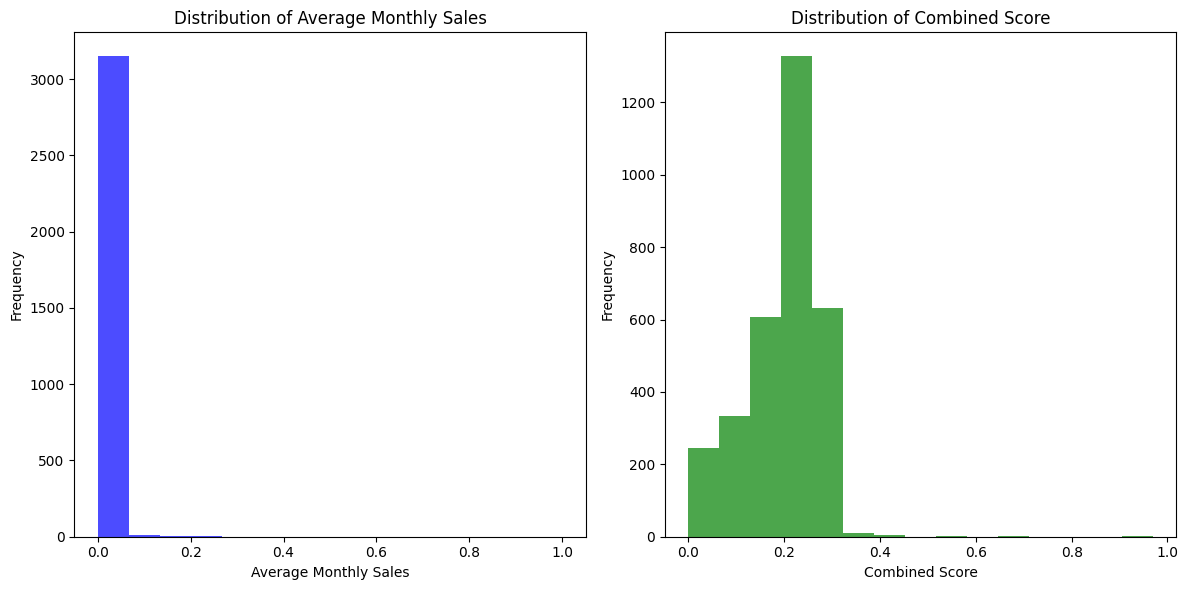

In [16]:
# 브랜드 충성도 feature engineering

# - Approach1: 월별 평균 판매량이 높을수록 브랜드의 충성도는 높을 것이다.
#     - 충성도 측정 방법: 브랜드별 월별 판매량 및 평균 판매량 계산 후 정규화 -> 값이 높을수록 충성도가 높은 브랜드임을 가정

# - Approach2: 월별 평균 판매량이 높고 일정할수록 브랜드의 충성도는 높을 것이다.
#     - 충성도 측정 방법: 평균 월별 판매량과 CV (Coefficient of Variation) 기반으로 각각 가중치 적용 후 weighted mean 계산 -> 값이 높을수록 충성도가 높은 브랜드임을 가정

class brand_popularity:
    def __init__(self, df: pd.DataFrame, w1, w2, target_df: pd.DataFrame):
        '''
        df: 브랜드별 월별 판매량이 산출된 df,
        w1: 월별 판매량에 적용할 가중치
        w2: 월별 판매량의 일정함(표준편차)에 적용할 가중치
        target_df: 계산된 feature를 mapping할 df
        '''
        self.df =df
        self.w1 = w1
        self.w2 = w2
        self.target_df = target_df

    def sales_based_popularity(self):
        '''
        브랜드별 월별 평균 판매량을 활용한 충성도 점수
        '''
        average_monthly_sales = self.df.mean()
        normalized_popularity = average_monthly_sales / average_monthly_sales.max()
        return normalized_popularity

    def mixed_based_popularity(self):
        '''
        월별 판매량과 판매량의 표준편차 (cv)를 활용한 충성도 점수
        '''
        average_monthly_sales = self.df.mean()
        normalized_popularity = average_monthly_sales / average_monthly_sales.max()
        cv = self.df.std() / self.df.mean()
        normalized_cv = cv / cv.max()

        combined_score = (self.w1 * normalized_popularity) + (self.w2 * (1 - normalized_cv))
        return combined_score

    def viz_distributions(self, score1, score2):
        '''
        feature의 분포를 확인합니다
        '''
        fig, axes = plt.subplots(1, 2, figsize=(12,6))

        axes[0].hist(score1, bins=15, color='blue', alpha=0.7)
        axes[0].set_title('Distribution of Average Monthly Sales')
        axes[0].set_xlabel('Average Monthly Sales')
        axes[0].set_ylabel('Frequency')

        axes[1].hist(score2, bins=15, color='green', alpha=0.7)
        axes[1].set_title('Distribution of Combined Score')
        axes[1].set_xlabel('Combined Score')
        axes[1].set_ylabel('Frequency')

        plt.tight_layout()
        plt.show()

    def map_feature(self, *features: list):
        '''
        계산된 feature를 원본 train 데이터에 맵핑합니다
        '''
        for i in range(len(features)):
            feature_dict = dict(zip(features[i].index, features[i].values))
            self.target_df['popularity'+str(i+1)] = self.target_df.브랜드.map(feature_dict)


get_popularity = brand_popularity(monthly_sales, 0.7, 0.3, train_df)
popularity1 = get_popularity.sales_based_popularity()
popularity2 = get_popularity.mixed_based_popularity()
get_popularity.viz_distributions(popularity1, popularity2)
get_popularity.map_feature(popularity1, popularity2)

In [17]:
# mapping한 피처들의 순서를 조정하고 결측치를 0으로 대체합니다
col_data = train_df.pop('popularity1')
train_df.insert(6, 'popularity1', col_data)
col_data2= train_df.pop('popularity2')
train_df.insert(7, 'popularity2', col_data2)
train_df.popularity2 = train_df.popularity2.fillna(0.0)
train_df.head()

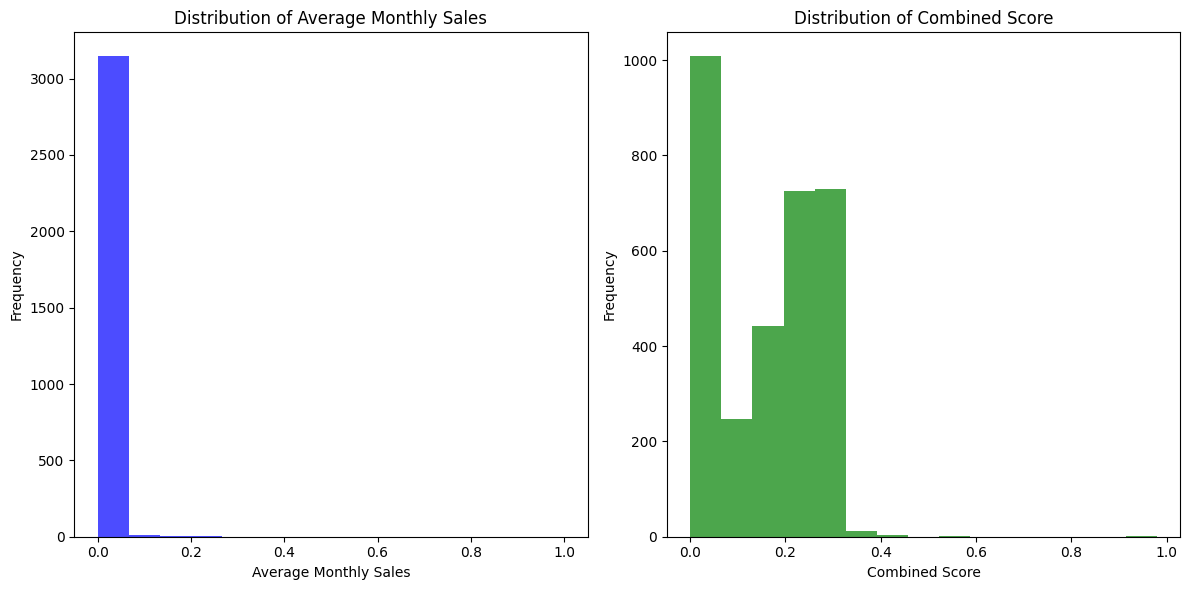

In [18]:
# 모델이 학습하는 3개월 동안의 데이터에만 기반하여 같은 방법으로 브랜드 충성도 feature 추출

# 2023년 1월, 2월, 3월 데이터로 데이터 프레임 변경
monthly_sales2 = monthly_sales.copy()
monthly_sales2 = monthly_sales2[12:15]

# popularity1, 2와 동일한 방법으로 popularity3, 4 계산
get_popularity = brand_popularity(monthly_sales2, 0.7, 0.3, train_df)
popularity3 = get_popularity.sales_based_popularity()
popularity4 = get_popularity.mixed_based_popularity()
popularity4 = popularity4.fillna(0.0) # popularity4에 존재하는 결측치는 0으로 대체
get_popularity.viz_distributions(popularity3, popularity4) # popularity3, 4의 분포를 시각화

feature_dict = dict(zip(popularity3.index, popularity3.values))
feature_dict2 = dict(zip(popularity4.index, popularity4.values))
train_df['popularity3'] = train_df.브랜드.map(feature_dict) # 원본 train_df에 mapping
train_df['popularity4'] = train_df.브랜드.map(feature_dict2) # 원본 train_df에 mapping

# 위와 같이 feature의 순서를 조정합니다
col_data = train_df.pop('popularity3')
train_df.insert(8, 'popularity3', col_data)
col_data2= train_df.pop('popularity4')
train_df.insert(9, 'popularity4', col_data2)

In [ ]:
# 추출된 4개 (popularity1 ~ 4) feature와 판매량과의 상관관계를 분석합니다.
df_features = train_df[['popularity1', 'popularity2', 'popularity3', 'popularity4']]
df_features['total_sales'] = train_df.iloc[:, 5:].iloc[:, 5:].sum(axis=1) # 브랜드별 총 판매량 계산 및 추가
df_features['avg_sales'] = train_df.iloc[:, 5:].iloc[:, 5:].mean(axis=1) # 브랜드별 평균 판매량 계산 및 추가

In [ ]:
# Pearson correlation matrix
df_features.corr()

In [ ]:
# 비선형 관계를 파악하기 위해 각 feature와 브랜드별 총 판매량 사이의 Distance correlation coefficients 계산합니다
display(spatial.distance.correlation(df_features['popularity1'], df_features['total_sales']))
display(spatial.distance.correlation(df_features['popularity2'], df_features['total_sales']))
display(spatial.distance.correlation(df_features['popularity3'], df_features['total_sales']))
display(spatial.distance.correlation(df_features['popularity4'], df_features['total_sales']))

In [ ]:
# 비선형 관계를 파악하기 위해 각 feature와 브랜드별 평균 판매량 사이의 Distance correlation coefficients 계산합니다
display(spatial.distance.correlation(df_features['popularity1'], df_features['avg_sales']))
display(spatial.distance.correlation(df_features['popularity2'], df_features['avg_sales']))
display(spatial.distance.correlation(df_features['popularity3'], df_features['avg_sales']))
display(spatial.distance.correlation(df_features['popularity4'], df_features['avg_sales']))

- popularity1이 판매량과 그나마 가장 강한 선형적인 관계를 나타냄 (0.24로 의미부여하기 어려운 상관계수이긴 하지만) 또 강한 비선형 관계를 나타냄 (0.76)
- populatiy4가 판매량과 가장 강한 비선형 관계를 나타냄 (0.84)
- 결과적으로 popularity1과 popularity4를 추가해서 테스트 해보는 것이 가장 이상적으로 보이기 때문에 최종 브랜드 충성도 feature는 popularity1, popoularity4로 선택

In [20]:
# 최종 브랜드 충성도 feature 선택 (popularity1, popularity4) 및 사용하지 않는 column 제거(ID, 제품)
train_df.drop(columns={'popularity2'}, inplace=True)
train_df.drop(columns={'popularity3'}, inplace=True)
train_df.drop(columns={'ID'}, inplace=True)
train_df.drop(columns={'제품'}, inplace=True)
train_df.head()

,대분류,중분류,소분류,브랜드,popularity1,popularity4,brand,2022-01-01,2022-01-02,2022-01-03,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
0,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,0.000024,0.130911,0.562504,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0.000229,0.228556,0.301587,0,0,0,...,1,1,1,1,3,2,0,0,2,0
2,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0.000229,0.228556,0.301587,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0.000229,0.228556,0.301587,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,B002-C001-0001,B002-C002-0001,B002-C003-0003,B002-00003,0.001209,0.224502,0.316015,0,0,0,...,3,2,0,0,0,0,0,0,0,0


#### **Scaling & Log transformation**


In [22]:
# 숫자형 변수들의 min-max scaling을 수행하는 코드입니다.
numeric_cols = train_df.columns[7:]
# 각 column의 min 및 max 계산
min_values = train_df[numeric_cols].min(axis=1)
max_values = train_df[numeric_cols].max(axis=1)
# 각 행의 범위(max-min)를 계산하고, 범위가 0인 경우 1로 대체
ranges = max_values - min_values
ranges[ranges == 0] = 1
# min-max scaling 수행
train_df[numeric_cols] = (train_df[numeric_cols].subtract(min_values, axis=0)).div(ranges, axis=0)
# max와 min 값을 dictionary 형태로 저장
scale_min_dict = min_values.to_dict()
scale_max_dict = max_values.to_dict()

In [ ]:
# Variance 안정화를 위해 로그 변환을 적용합니다.

def log_transformation(df: pd.DataFrame, start_date, offset = float):
    '''
    정상성 변환을 위해 로그 변환을 적용합니다.
    0이 많은 데이터 특성 때문에 일반적인 로그 변환보다는, 전체 데이터에 offset을 더하고 로그 변환을 진행합니다.
    '''
    df_log = df.copy()
    df_log = df_log.iloc[:, df.columns.get_loc(start_date):] + offset
    df_log = np.log(df_log)
    df.iloc[:, df.columns.get_loc('2022-01-01'):]  = df_log

    return df

train_data = log_transformation(train_df, '2022-01-01', 1)

In [ ]:
# Label Encoding
label_encoder = LabelEncoder()
categorical_columns = ['대분류', '중분류', '소분류', '브랜드']

for col in categorical_columns:
    label_encoder.fit(train_data[col])
    train_data[col] = label_encoder.transform(train_data[col])

train_data.head()

In [26]:
def make_train_data(data, train_size=CFG['TRAIN_WINDOW_SIZE'], predict_size=CFG['PREDICT_SIZE']):
    STEP_SIZE = 2

    num_rows = len(data)
    window_size = train_size + predict_size
    adjusted_size = (len(data.columns) - window_size + 1) // STEP_SIZE

    input_data = np.empty((num_rows * adjusted_size, train_size, len(data.iloc[0, :7]) + 1))
    target_data = np.empty((num_rows * adjusted_size, predict_size))

    for i in tqdm(range(num_rows)):
        encode_info = np.array(data.iloc[i, :7])
        sales_data = np.array(data.iloc[i, 7:])

        for j in range(0, len(sales_data) - window_size + 1, STEP_SIZE):
            window = sales_data[j: j + window_size]
            temp_data = np.column_stack((np.tile(encode_info, (train_size, 1)), window[:train_size]))
            input_data[i * adjusted_size + j // STEP_SIZE] = temp_data
            target_data[i * adjusted_size + j // STEP_SIZE] = window[train_size:]

    return input_data, target_data
    '''
    학습 기간 블럭, 예측 기간 블럭의 세트로 데이터를 생성
    data : 일별 판매량
    train_size : 학습에 활용할 기간
    predict_size : 추론할 기간
    '''

In [27]:
def make_predict_data(data, train_size=CFG['TRAIN_WINDOW_SIZE']):
    '''
    평가 데이터(Test Dataset)를 추론하기 위한 Input 데이터를 생성
    data : 일별 판매량
    train_size : 추론을 위해 필요한 일별 판매량 기간 (= 학습에 활용할 기간)
    '''
    num_rows = len(data)

    input_data = np.empty((num_rows, train_size, len(data.iloc[0, :7]) + 1))

    for i in tqdm(range(num_rows)):
        encode_info = np.array(data.iloc[i, :7])
        sales_data = np.array(data.iloc[i, -train_size:])

        window = sales_data[-train_size : ]
        temp_data = np.column_stack((np.tile(encode_info, (train_size, 1)), window[:train_size]))
        input_data[i] = temp_data

    return input_data

In [28]:
train_input, train_target = make_train_data(train_data)
test_input = make_predict_data(train_data)

  0%|          | 0/15890 [00:00<?, ?it/s]

  0%|          | 0/15890 [00:00<?, ?it/s]

In [29]:
# Train / Validation Split
data_len = len(train_input)
val_input = train_input[-int(data_len*0.2):]
val_target = train_target[-int(data_len*0.2):]
train_input = train_input[:-int(data_len*0.2)]
train_target = train_target[:-int(data_len*0.2)]

In [30]:
train_input.shape, train_target.shape, val_input.shape, val_target.shape, test_input.shape

((2453416, 60, 8),
 (2453416, 21),
 (613354, 60, 8),
 (613354, 21),
 (15890, 60, 8))

### **Custom Dataset**

In [31]:
class CustomDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __getitem__(self, index):
        if self.Y is not None:
            return torch.Tensor(self.X[index]), torch.Tensor(self.Y[index])
        return torch.Tensor(self.X[index])

    def __len__(self):
        return len(self.X)

In [32]:
train_dataset = CustomDataset(train_input, train_target)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=1)

val_dataset = CustomDataset(val_input, val_target)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=1)

### **모델 선언**

In [34]:
import torch
import torch.nn as nn

class Conv1dLSTMModel(nn.Module):
    def __init__(self, input_size=8, hidden_size=512, output_size=CFG['PREDICT_SIZE']):
        super(Conv1dLSTMModel, self).__init__()
        self.conv1d_1 = nn.Conv1d(in_channels=input_size,
                                out_channels=16,
                                kernel_size=3,
                                stride=1,
                                padding=1)
        self.conv1d_2 = nn.Conv1d(in_channels=16,
                                out_channels=32,
                                kernel_size=3,
                                stride=1,
                                padding=1)
        self.lstm = nn.LSTM(input_size=32,
                            hidden_size=hidden_size,
                            num_layers=2,
                            bias=True,
                            bidirectional=False,
                            batch_first=True)
        self.dropout = nn.Dropout(0.1)

        self.fc_layer1 = nn.Linear(512, 32)
        self.fc_layer2 = nn.Linear(32, output_size)

    def forward(self, x):
        x = x.transpose(1, 2)

        x = self.conv1d_1(x)

        x = self.conv1d_2(x)

        x = x.transpose(1, 2)

        self.lstm.flatten_parameters()

        _, (hidden, _) = self.lstm(x)

        x = hidden[-1]

        x = self.dropout(x)

        x = self.fc_layer1(x)
        x = self.fc_layer2(x)

        return x

### **모델 학습**

In [35]:
def train_with_early_stopping(model, optimizer, train_loader, val_loader, device, patience=3):
    model.to(device)
    criterion = nn.MSELoss().to(device)
    best_loss = float('inf')
    best_model = None
    no_improvement_count = 0  # 변수 초기화

    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []

        for X, Y in tqdm(iter(train_loader)):
            X = X.to(device)
            Y = Y.to(device)

            optimizer.zero_grad()

            output = model(X)
            loss = criterion(output, Y)

            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

        val_loss = validation(model, val_loader, criterion, device)
        print(f'Epoch : [{epoch}] Train Loss : [{np.mean(train_loss):.5f}] Val Loss : [{val_loss:.5f}]')

        if val_loss < best_loss:  # 검증 손실이 감소한 경우
            best_loss = val_loss
            best_model = model
            no_improvement_count = 0  # 카운트 초기화
            print('Model Saved')
        else:
            no_improvement_count += 1

        if no_improvement_count >= patience:  # 일정 epoch 동안 검증 손실이 향상되지 않으면 종료
            print(f'Early stopping! No improvement for {patience} epochs.')
            print(f'TRAIN_WINDOW_SIZE : {CFG["TRAIN_WINDOW_SIZE"]}, PREDICT_SIZE : {CFG["PREDICT_SIZE"]}, EPOCHS : {CFG["EPOCHS"]}, LEARNING_RATE : {CFG["LEARNING_RATE"]}, BATCH_SIZE : {CFG["BATCH_SIZE"]}, SEED : {CFG["SEED"]}')
            break

    return best_model

In [36]:
def validation(model, val_loader, criterion, device):
    model.eval()
    val_loss = []

    with torch.no_grad():
        for X, Y in tqdm(iter(val_loader)):
            X = X.to(device)
            Y = Y.to(device)

            output = model(X)
            loss = criterion(output, Y)

            val_loss.append(loss.item())
    return np.mean(val_loss)

### **Run !!**


In [37]:
model = Conv1dLSTMModel()
optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
infer_model = train_with_early_stopping(model, optimizer, train_loader, val_loader, device)

  0%|          | 0/2396 [00:00<?, ?it/s]

  0%|          | 0/599 [00:00<?, ?it/s]

Epoch : [1] Train Loss : [0.01959] Val Loss : [0.01914]
Model Saved


  0%|          | 0/2396 [00:00<?, ?it/s]

  0%|          | 0/599 [00:00<?, ?it/s]

Epoch : [2] Train Loss : [0.01869] Val Loss : [0.01904]
Model Saved


  0%|          | 0/2396 [00:00<?, ?it/s]

  0%|          | 0/599 [00:00<?, ?it/s]

Epoch : [3] Train Loss : [0.01808] Val Loss : [0.01919]


  0%|          | 0/2396 [00:00<?, ?it/s]

  0%|          | 0/599 [00:00<?, ?it/s]

Epoch : [4] Train Loss : [0.01753] Val Loss : [0.01877]
Model Saved


  0%|          | 0/2396 [00:00<?, ?it/s]

  0%|          | 0/599 [00:00<?, ?it/s]

Epoch : [5] Train Loss : [0.01744] Val Loss : [0.01928]


  0%|          | 0/2396 [00:00<?, ?it/s]

  0%|          | 0/599 [00:00<?, ?it/s]

Epoch : [6] Train Loss : [0.01786] Val Loss : [0.01927]


  0%|          | 0/2396 [00:00<?, ?it/s]

  0%|          | 0/599 [00:00<?, ?it/s]

Epoch : [7] Train Loss : [0.01630] Val Loss : [0.01791]
Model Saved


  0%|          | 0/2396 [00:00<?, ?it/s]

  0%|          | 0/599 [00:00<?, ?it/s]

Epoch : [8] Train Loss : [0.01508] Val Loss : [0.01659]
Model Saved


  0%|          | 0/2396 [00:00<?, ?it/s]

  0%|          | 0/599 [00:00<?, ?it/s]

Epoch : [9] Train Loss : [0.01097] Val Loss : [0.01012]
Model Saved


  0%|          | 0/2396 [00:00<?, ?it/s]

  0%|          | 0/599 [00:00<?, ?it/s]

Epoch : [10] Train Loss : [0.01015] Val Loss : [0.01017]


  0%|          | 0/2396 [00:00<?, ?it/s]

  0%|          | 0/599 [00:00<?, ?it/s]

Epoch : [11] Train Loss : [0.01136] Val Loss : [0.01788]


  0%|          | 0/2396 [00:00<?, ?it/s]

  0%|          | 0/599 [00:00<?, ?it/s]

Epoch : [12] Train Loss : [0.01073] Val Loss : [0.00993]
Model Saved


  0%|          | 0/2396 [00:00<?, ?it/s]

  0%|          | 0/599 [00:00<?, ?it/s]

Epoch : [13] Train Loss : [0.00979] Val Loss : [0.00980]
Model Saved


  0%|          | 0/2396 [00:00<?, ?it/s]

  0%|          | 0/599 [00:00<?, ?it/s]

Epoch : [14] Train Loss : [0.00974] Val Loss : [0.00966]
Model Saved


  0%|          | 0/2396 [00:00<?, ?it/s]

  0%|          | 0/599 [00:00<?, ?it/s]

Epoch : [15] Train Loss : [0.00968] Val Loss : [0.01058]


  0%|          | 0/2396 [00:00<?, ?it/s]

  0%|          | 0/599 [00:00<?, ?it/s]

Epoch : [16] Train Loss : [0.00967] Val Loss : [0.00970]


  0%|          | 0/2396 [00:00<?, ?it/s]

  0%|          | 0/599 [00:00<?, ?it/s]

Epoch : [17] Train Loss : [0.00963] Val Loss : [0.00996]
Early stopping! No improvement for 3 epochs.
TRAIN_WINDOW_SIZE : 60, PREDICT_SIZE : 21, EPOCHS : 20, LEARNING_RATE : 7.5e-05, BATCH_SIZE : 1024, SEED : 777


### **모델 추론**

In [38]:
test_dataset = CustomDataset(test_input, None)
test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=1)

In [39]:
def inference(model, test_loader, device):
    predictions = []

    with torch.no_grad():
        for X in tqdm(iter(test_loader)):
            X = X.to(device)

            output = model(X)

            # 모델 출력인 output을 CPU로 이동하고 numpy 배열로 변환
            output = output.cpu().numpy()

            predictions.extend(output)

    return np.array(predictions)

In [40]:
pred = inference(infer_model, test_loader, device)
pred = pd.DataFrame(pred)

  0%|          | 0/16 [00:00<?, ?it/s]

In [43]:
# inverse log transformation
offset = 1
pred = np.exp(pred) - offset

# 추론 결과를 inverse scaling
for idx in tqdm(range(len(pred))):
    pred.iloc[idx, :] = pred.iloc[idx, :] * (scale_max_dict[idx] - scale_min_dict[idx]) + scale_min_dict[idx]

# 결과 후처리
pred = np.round(pred, 0).astype(int)

  0%|          | 0/15890 [00:00<?, ?it/s]

In [44]:
pred.shape

(15890, 21)

### **Submission**

In [45]:
submit = pd.read_csv('/content/drive/MyDrive/sample_submission.csv')
submit.head()

,ID,2023-04-05,2023-04-06,2023-04-07,2023-04-08,2023-04-09,2023-04-10,2023-04-11,2023-04-12,2023-04-13,...,2023-04-16,2023-04-17,2023-04-18,2023-04-19,2023-04-20,2023-04-21,2023-04-22,2023-04-23,2023-04-24,2023-04-25
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
submit.iloc[:,1:] = pred
submit.head()

,ID,2023-04-05,2023-04-06,2023-04-07,2023-04-08,2023-04-09,2023-04-10,2023-04-11,2023-04-12,2023-04-13,...,2023-04-16,2023-04-17,2023-04-18,2023-04-19,2023-04-20,2023-04-21,2023-04-22,2023-04-23,2023-04-24,2023-04-25
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,1,0,0,0,1,0,0,...,0,1,1,0,1,1,1,1,1,1
4,4,1,1,1,1,1,1,1,1,1,...,1,2,2,2,2,2,2,2,2,2


In [47]:
submit.to_csv('/content/drive/MyDrive/final_code_check.csv', index=False)